In [1]:
# useful additional packages 
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import numpy as np
import networkx as nx
from qiskit import Aer, execute, QuantumCircuit
from qiskit.quantum_info import Statevector

# auxilliary function to plot graphs
def plot_result(G, x):
    colors = ['r' if x[i] == 0 else 'b' for i in range(n)]
    pos, default_axes = nx.spring_layout(G), plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, pos=pos)

# An Introduction to Quantum Optimization
<br>

Stefan Woerner<br>
IBM Quantum, IBM Research - Zurich<br>
<br>

# 1. Introduction

# Combinatorial Optimization

### Example: Binary Optimization

Given a function $f: \{0, 1\}^n \rightarrow \mathbb{R}$ find a bit-string $[b_0, \ldots, b_{n-1}]$ that minimizes $f$.

This finds plenty of applications, such as 
- supply chain optimization, 
- financial portfolio optimization, or
- protein folding.

In the following we will change between the binary and the integer representation, i.e., we switch between 

-  $[b_0, \ldots, b_{n-1}] \in \{0, 1\}^n$ and
-  $x \in \{0, \ldots, 2^n-1\}$.



# "Quantum Computers can evaluate all possible solutions at the same time..."

# <font color="red">"Quantum Computers can evaluate all possible solutions at the same time..."</font>
## $\rightarrow$ A common misunderstanding, particularly for combinatorial optimization!

Suppose the equal superposition state

$$
|+\rangle_n = H^{\otimes n} |0\rangle_n = \frac{1}{\sqrt{2^n}} \sum_{x=0}^{2^n-1} |x\rangle_n
$$

Furthermore, suppose a function $f: \{0, \ldots, 2^n-1\} \rightarrow \mathbb{R}$ and a corresponding quantum operation

$$
F: |x\rangle_n|0\rangle_m \mapsto |x\rangle_n|f(x)\rangle_m
$$

Thus, we get

$$
F |+\rangle_n|0\rangle_m = \frac{1}{\sqrt{2^n}} \sum_{x=0}^{2^n-1} |x\rangle_n|f(x)\rangle_m
$$

and the quantum computer evaluates the exponential number of solultions in parallel! 

Doesn't it?

Unfortunately,
- it remains an exponential number of possible solutions.
- the quantum computer does NOT tell us which one achieves the optimum.
- if we measure the qubits in the state above, we just sample every possible solution with the same probability of $1/2^n$, as we could easily do classically.
<br>
<br>
<br>
<font color="orange">$\rightarrow$ To get a quantum computer to tell us the optimal solution of a combinatorial optimization problem with probability higher than $1/2^n$, we have to work a bit harder...</font>

# 2. Qiskit Optimization

# Qiskit Optimization

<br>
<div>
    <center>
        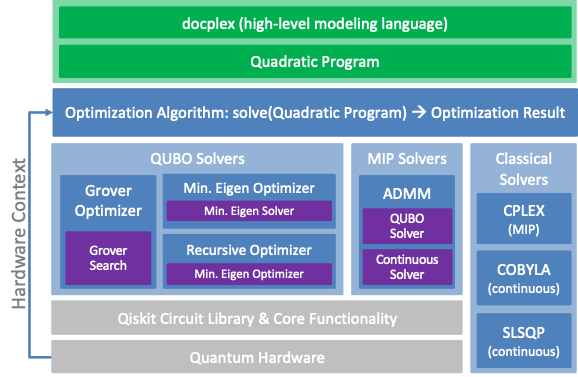
        <br>
        https://medium.com/qiskit: A Walkthrough of Qiskit’s New Optimization Module
    </center>
</div>

## Quadratically Constrained Quadratic Programs

<br>

$$
\min_{x \in X} \, x^T A x + b^T x + c \\
\,\\
\text{subject to}\\
x^T A_i x + b_i^T x + c_i \leq 0, \quad i=1, \ldots, r,\\
\,\\
\text{where}\\
X = \mathbb{R}^n \times \mathbb{Z}^m \times \{0, 1\}^k\\
A \in \mathbb{R}^{(n+m+k) \times (n+m+k)}\\
b \in \mathbb{R}^{(n+m+k)}\\
c \in \mathbb{R}
$$

## Quadratic Unconstrained Binary Optimization (QUBO)

<br>

$$
\min_{x \in \{0, 1\}^k} \, x^T A x + c \\
$$

For binary variables $x^2 = x$, thus, the linear part can be added to the diagonal of the quadratic part.

## Example: MaxCut

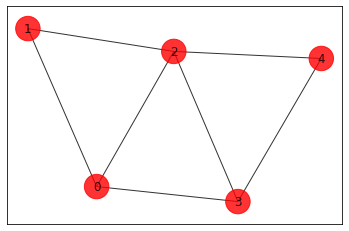

In [2]:
# create graph
G = nx.Graph()

# add nodes
n = 5
G.add_nodes_from(range(n))

# add edges: tuple is (i,j,weight) where (i,j) is the edge
edges = [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0), (2, 4, 1.0), (3, 4, 1.0)]
G.add_weighted_edges_from(edges)

# plot graph
plot_result(G, [0]*n)

## Example: Modeling MaxCut with DOcplex

<br>

$$
\max_{x \in \{0, 1\}^n} \sum_{(i, j) \in E} w_{ij} (x_i + x_j - 2 x_i x_j)
$$

In [3]:
from docplex.mp.model import Model

mdl = Model('MaxCut')
x = mdl.binary_var_list('x{}'.format(i) for i in range(n))

objective = mdl.sum([ w * (x[i] + x[j] - 2*x[i]*x[j]) for (i, j, w) in edges])
mdl.maximize(objective)

mdl.prettyprint()

// This file has been generated by DOcplex
// model name is: MaxCut
// var contrainer section
dvar bool x[5];

maximize
 3 x0 + 2 x1 + 4 x2 + 3 x3 + 2 x4 [ - 2 x0*x1 - 2 x0*x2 - 2 x0*x3 - 2 x1*x2
 - 2 x2*x3 - 2 x2*x4 - 2 x3*x4 ];
 
subject to {

}


## Example: Adding a Constraint

<br>

$$
\max_{x \in \{0, 1\}^n} \sum_{(i, j) \in E} w_{ij} (x_i + x_j - 2 x_i x_j) \\
\text{subject to:} \sum_{i=0}^{n-1} x_i = b
$$

In [4]:
b = 2
mdl.add_constraint(mdl.sum(x) == b)
mdl.prettyprint()

// This file has been generated by DOcplex
// model name is: MaxCut
// var contrainer section
dvar bool x[5];

maximize
 3 x0 + 2 x1 + 4 x2 + 3 x3 + 2 x4 [ - 2 x0*x1 - 2 x0*x2 - 2 x0*x3 - 2 x1*x2
 - 2 x2*x3 - 2 x2*x4 - 2 x3*x4 ];
 
subject to {
 x0 + x1 + x2 + x3 + x4 == 2;

}


## Example: Create and solve `QuadraticProgram` with DOcplex

optimal function value: 5.0
optimal value: [0. 0. 1. 1. 0.]
status: SUCCESS


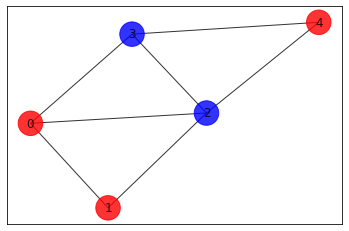

In [5]:
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.algorithms import CplexOptimizer

# convert from DOcplex model to Qiskit Quadratic Program
qp = QuadraticProgram()
qp.from_docplex(mdl)

# Solve Quadratic Program using CPLEX
cplex = CplexOptimizer()
result = cplex.solve(qp)
print(result)
plot_result(G, result.x)

# 3. Optimization via Ising Hamiltonian

## Conversion to QUBO

Qiskit's Optimization module provides converters for Quadratic Programs:

In [6]:
from qiskit_optimization.converters import (
    InequalityToEquality,     # converts inequality constraints to equality constraints by adding slack variables
    LinearEqualityToPenalty,  # converts linear equality constraints to quadratic penalty terms 
    IntegerToBinary,          # converts integer variables to binary variables
    QuadraticProgramToQubo    # combines the previous three converters
)

## Linear Equality Constraint to Quadratic Penalty Term

In [7]:
lineq2penalty = LinearEqualityToPenalty(penalty=1)
qp_wo_constr = lineq2penalty.convert(qp)
qp_wo_constr

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: MaxCut

Maximize
 obj: 7 x0 + 6 x1 + 8 x2 + 7 x3 + 6 x4 + [ - 2 x0^2 - 8 x0*x1 - 8 x0*x2
      - 8 x0*x3 - 4 x0*x4 - 2 x1^2 - 8 x1*x2 - 4 x1*x3 - 4 x1*x4 - 2 x2^2
      - 8 x2*x3 - 8 x2*x4 - 2 x3^2 - 8 x3*x4 - 2 x4^2 ]/2 -4
Subject To

Bounds
 0 <= x0 <= 1
 0 <= x1 <= 1
 0 <= x2 <= 1
 0 <= x3 <= 1
 0 <= x4 <= 1

Binaries
 x0 x1 x2 x3 x4
End

optimal function value: 5.0
optimal value: [1. 0. 0. 0. 1.]
status: SUCCESS


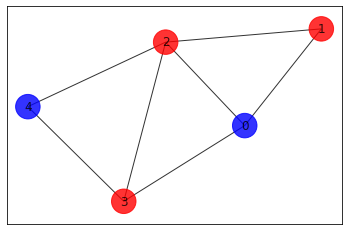

In [8]:
# Solve converted Quadratic Program using CPLEX
result = cplex.solve(qp_wo_constr)
print(result)
plot_result(G, result.x)

## Mapping of QUBO to Ising Hamiltonian

Suppose a QUBO
$$
\min_{x \in \{0, 1\}^n} \sum_{i,j=0}^{n-1} A_{ij} x_i x_j + c
$$

1. Substitute<br>
$x_i = (1 - z_i)/2,$<br>
where $z_i \in \{-1, +1\}$.
<br>

2. Replace<br>
$z_i z_j = \sigma_Z^i \otimes \sigma_Z^j$, and<br>
$z_i = \sigma_Z^i$,<br>
where $\sigma_Z^i$ denotes the Pauli Z-matrix $\left(\begin{array}{cc}1&0\\0&-1\end{array}\right)$ on the <font color="blue">$i$-th qubit</font>.

## From QUBO to Finding Hamiltonian Groundstates

Suppose a QUBO
$$
\min_{x \in \{0, 1\}^n} \sum_{i,j=0}^{n-1} A_{ij} x_i x_j + c
$$

which has been mapped to an Ising Hamiltonian:
$$
H = \sum_{i,j=0}^{n-1} \tilde{A}_{ij} \sigma_Z^i \otimes \sigma_Z^j + \sum_{i=0}^{n-1} \tilde{b}_i \sigma_Z^i + \tilde{c}
$$

Finding the groundstate of $H$ is equivalent to solving the QUBO:

$$
\min_{|\psi\rangle_n} \, \langle \psi |H| \psi \rangle_n
$$

<br>

<b>Remark:</b> $H$ is diagonal, and thus, all computational basis states $|x\rangle_n$ are eigenstates.

In [9]:
H, offset = qp_wo_constr.to_ising()
print('offset =', offset)
print()
print('H =', H)

offset = -2.0

H = -0.5 * ZIIII
- 0.5 * IZIII
+ 1.0 * ZZIII
- 0.5 * IIZII
+ 1.0 * ZIZII
+ 1.0 * IZZII
- 0.5 * IIIZI
+ 0.5 * ZIIZI
+ 0.5 * IZIZI
+ 1.0 * IIZZI
- 0.5 * IIIIZ
+ 0.5 * ZIIIZ
+ 1.0 * IZIIZ
+ 1.0 * IIZIZ
+ 1.0 * IIIZZ


dim(H): (32, 32)
[[ 6.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  4.  0.  0.]
 [ 0.  0.  0. ...  0.  3.  0.]
 [ 0.  0.  0. ...  0.  0. 11.]]


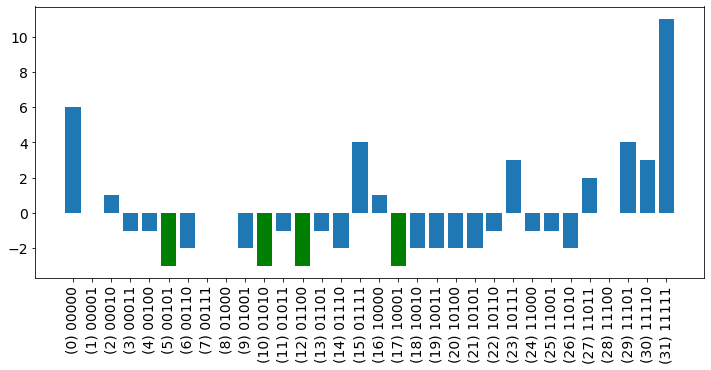

In [10]:
# print Ising Hamiltonian as matrix
H_matrix = np.real(H.to_matrix())
print('dim(H):', H_matrix.shape)
print(H_matrix)

# plot diagonal of matrix
opt_indices = list(np.where(H_matrix.diagonal() == min(H_matrix.diagonal())))[0]
plt.figure(figsize=(12, 5))
plt.bar(range(2**n), H_matrix.diagonal())
plt.bar(opt_indices, H_matrix.diagonal()[opt_indices], color='g')
plt.xticks(range(2**n), ['('+str(i)+') {0:05b}'.format(i) for i in range(2**n)], rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.show()

## Variational Quantum Eigensolver (VQE)

Replace minimization over all $|\psi\rangle$ by minimization over a parametrized subset $|\psi(\theta)\rangle$:
<br>

$$
\min_{\theta} \langle \psi(\theta) |H| \psi(\theta) \rangle
$$

## VQE with `RealAmplitudes` Circuit

In [11]:
from qiskit.circuit.library import RealAmplitudes
qc = RealAmplitudes(5, reps=1)
qc.draw(fold=120)

┌──────────┐                         ┌──────────┐                                              
q_0: ┤ RY(θ[0]) ├──■────■────■─────────■──┤ RY(θ[5]) ├──────────────────────────────────────────────
     ├──────────┤┌─┴─┐  │    │         │  └──────────┘     ┌──────────┐                             
q_1: ┤ RY(θ[1]) ├┤ X ├──┼────┼────■────┼───────■────────■──┤ RY(θ[6]) ├─────────────────────────────
     ├──────────┤└───┘┌─┴─┐  │  ┌─┴─┐  │       │        │  └──────────┘     ┌──────────┐            
q_2: ┤ RY(θ[2]) ├─────┤ X ├──┼──┤ X ├──┼───────┼────────┼───────■────────■──┤ RY(θ[7]) ├────────────
     ├──────────┤     └───┘┌─┴─┐└───┘  │     ┌─┴─┐      │     ┌─┴─┐      │  └──────────┘┌──────────┐
q_3: ┤ RY(θ[3]) ├──────────┤ X ├───────┼─────┤ X ├──────┼─────┤ X ├──────┼───────■──────┤ RY(θ[8]) ├
     ├──────────┤          └───┘     ┌─┴─┐   └───┘    ┌─┴─┐   └───┘    ┌─┴─┐   ┌─┴─┐    ├──────────┤
q_4: ┤ RY(θ[4]) ├────────────────────┤ X ├────────────┤ X ├────────────┤ X ├───┤ X ├────┤ RY(θ[9]) ├
     └──────────┘                    └───┘            └───┘            └───┘   └───┘    └──────────┘

optimal value: -3.0


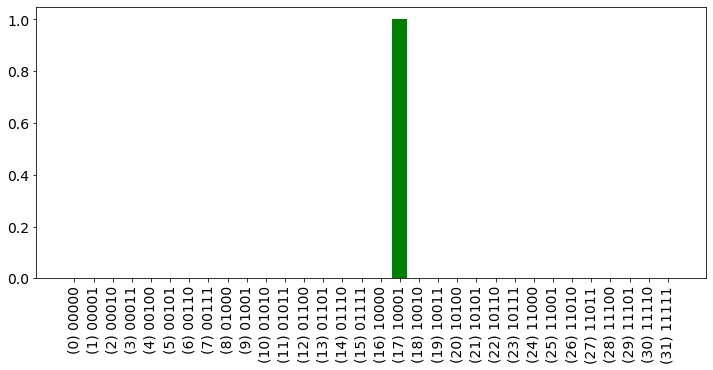

In [12]:
# run VQE
from qiskit.algorithms import VQE
vqe = VQE(qc, quantum_instance=Aer.get_backend('statevector_simulator'))
result = vqe.compute_minimum_eigenvalue(H)
print('optimal value:', np.round(result.eigenvalue, decimals=4))

# plot probabilities
probabilities = np.abs(result.eigenstate)**2
plt.figure(figsize=(12, 5))
plt.bar(range(2**n), probabilities)
plt.bar(opt_indices, probabilities[opt_indices], color='g')
plt.xticks(range(2**n), ['('+str(i)+') {0:05b}'.format(i) for i in range(2**n)], rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### How should we choose $|\psi(\theta)\rangle$ for a particular problem?

## The Adiabatic Theorem
> A physical system remains in its instantaneous eigenstate if a given perturbation is acting on it slowly enough and if there is a gap between the eigenvalue and the rest of the Hamiltonian's spectrum. <br><br>
> M. Born and V. A. Fock (1928). "Beweis des Adiabatensatzes".<br>Zeitschrift für Physik A. 51 (3–4): 165–180.<br>
https://en.wikipedia.org/wiki/Adiabatic_theorem

## Trotterized Annealing: General Idea

Given a cost Hamiltonian $H_C$ that encodes a QUBO:
1. Find simple Hamiltonian $H_X$ with easy-to-prepare groundstate $|\psi_0\rangle$<br>that has non-zero overlap with the groundstate of $H_C$.

2. Slowly drive the system away from $|\psi_0\rangle$ over time $t \in [0, T]$, following the dynamics defined by the time-dependent Hamiltonian
$$
H_t = \frac{t}{T} H_C + (1 - \frac{t}{T}) H_X.
$$

If done slowly enough, the Adiabatic Theorem implies that the system will stay in the groundstate of $H_t$ for all $t$. Thus, will end in the groundstate $H_C$, i.e., the optimal solution of the QUBO.

## Trotterized Annealing: Common Setting

A common choice is

$$
H_X = -\sum_{i=1}^n \sigma_X^i,
$$

where $\sigma_X^i$ denotes the Pauli X-matrix on qubit $i$.
The corresponding groundstate is given by

$$
|\psi_0\rangle = \frac{1}{\sqrt{2^n}}\sum_{k=0}^{2^n-1} |k\rangle.
$$

This state has overlap with every other state and can be easily prepared using Hadamard gates.

## Trotterized Annealing: Single Qubit Example

Suppose

$$
H_C = \sigma_Z = 
\left(\begin{array}{cc}
1 & 0 \\ 0 & -1
\end{array}\right)
$$

with <font color="blue">groundstate $|1\rangle$ and optimal value -1</font>.
Then,

$$
H_t = \frac{t}{T} \sigma_Z - (1 - \frac{t}{T}) \sigma_X.
$$

The annealing process can then be approximated by setting

$$ 
|\psi_{t+1}\rangle = e^{-iH_t \Delta t}|\psi_{t}\rangle
$$

for a small time step $\Delta t$. The matrices $\sigma_Z$ and $\sigma_X$ do not commute, however, we can trotterize, i.e., we first apply $e^{-i \frac{t}{T} H_C \Delta t}$ and then $e^{-i (1 - \frac{t}{T}) H_X \Delta t}$, and for sufficiently small $\Delta t$ only introduce a small error.

Thus, we have

$$
e^{-i \frac{t}{T} H_C \Delta t} = e^{-i \sigma_Z \frac{\gamma_t}{2}} = R_Z(\gamma_t),
$$

and

$$
e^{-i (1 - \frac{t}{T}) H_X \Delta t} = e^{-i \sigma_X \frac{\beta_t}{2}} = R_X(\beta_t)
$$

for rotation angles $\gamma_t = 2 t/T \Delta t$ and $\beta_t = -2(1 - t/T) \Delta t$.

In [13]:
from qiskit.circuit import Parameter
gamma, beta = Parameter('gamma'), Parameter('beta')

qc = QuantumCircuit(1)
qc.h(0)
qc.barrier()
qc.rz(gamma, 0)
qc.rx(beta, 0)
qc.barrier()
qc.draw()

┌───┐ ░ ┌───────────┐┌──────────┐ ░ 
q_0: ┤ H ├─░─┤ RZ(gamma) ├┤ RX(beta) ├─░─
     └───┘ ░ └───────────┘└──────────┘ ░

In [14]:
def construct_schedule(T, N):
    delta_t = T/N
    gammas, betas = [], []  # H_C, H_X parameters
    for i in range(N+1):
        t = i * delta_t
        gammas += [ 2 * delta_t * t/T ]  # H_C
        betas += [ -2 * delta_t * (1 - t/T) ]  # H_X
    return gammas, betas

In [15]:
T = 5
N = 10
gammas, betas = construct_schedule(T, N)

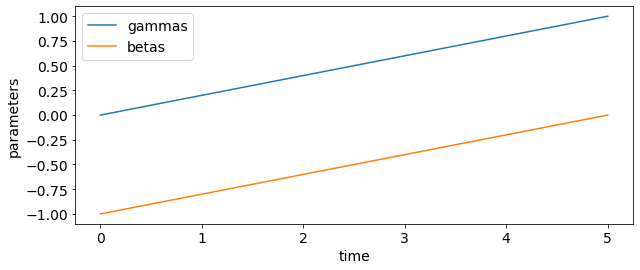

In [16]:
plt.figure(figsize=(10, 4))
plt.plot(np.linspace(0, T, N+1), gammas, label='gammas')
plt.plot(np.linspace(0, T, N+1), betas, label='betas')
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel('time', fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('parameters', fontsize=14);

In [17]:
# track probabilities during trotterized annealing
probabilities = np.zeros((2, N+1))

# construct circuit
qc = QuantumCircuit(1)
qc.h(0)
qc.barrier()
for i, (gamma, beta) in enumerate(zip(gammas, betas)):
    qc.rz(gamma, 0)
    qc.rx(beta, 0)
    qc.barrier()
    probabilities[:, i] = Statevector.from_instruction(qc).probabilities()
qc.draw()

┌───┐ ░ ┌───────┐┌────────┐ ░ ┌─────────┐┌──────────┐ ░ ┌─────────┐»
q_0: ┤ H ├─░─┤ RZ(0) ├┤ RX(-1) ├─░─┤ RZ(0.1) ├┤ RX(-0.9) ├─░─┤ RZ(0.2) ├»
     └───┘ ░ └───────┘└────────┘ ░ └─────────┘└──────────┘ ░ └─────────┘»
«     ┌──────────┐ ░ ┌─────────┐┌──────────┐ ░ ┌─────────┐┌──────────┐ ░ »
«q_0: ┤ RX(-0.8) ├─░─┤ RZ(0.3) ├┤ RX(-0.7) ├─░─┤ RZ(0.4) ├┤ RX(-0.6) ├─░─»
«     └──────────┘ ░ └─────────┘└──────────┘ ░ └─────────┘└──────────┘ ░ »
«     ┌─────────┐┌──────────┐ ░ ┌─────────┐┌──────────┐ ░ ┌─────────┐»
«q_0: ┤ RZ(0.5) ├┤ RX(-0.5) ├─░─┤ RZ(0.6) ├┤ RX(-0.4) ├─░─┤ RZ(0.7) ├»
«     └─────────┘└──────────┘ ░ └─────────┘└──────────┘ ░ └─────────┘»
«     ┌──────────┐ ░ ┌─────────┐┌──────────┐ ░ ┌─────────┐┌──────────┐ ░ »
«q_0: ┤ RX(-0.3) ├─░─┤ RZ(0.8) ├┤ RX(-0.2) ├─░─┤ RZ(0.9) ├┤ RX(-0.1) ├─░─»
«     └──────────┘ ░ └─────────┘└──────────┘ ░ └─────────┘└──────────┘ ░ »
«     ┌───────┐┌───────┐ ░ 
«q_0: ┤ RZ(1) ├┤ RX(0) ├─░─
«     └───────┘└───────┘ ░

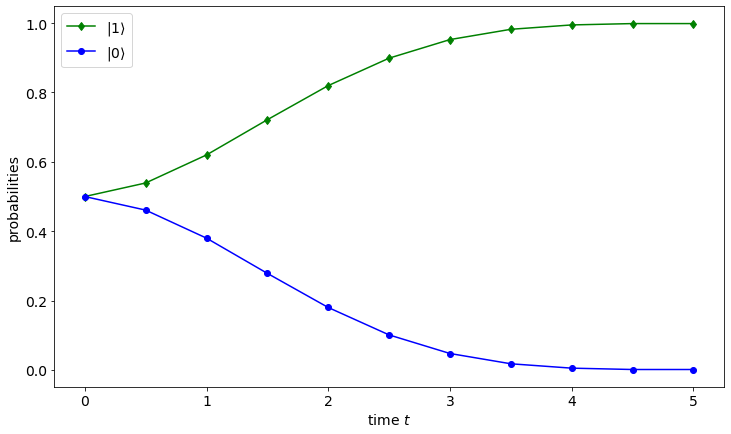

In [18]:
plt.figure(figsize=(12, 7))
plt.plot(np.linspace(0, T, N+1), probabilities[1, :], 'gd-', label=r'$|1\rangle$')
plt.plot(np.linspace(0, T, N+1), probabilities[0, :], 'bo-', label=r'$|0\rangle$')
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel('time $t$', fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('probabilities', fontsize=14);

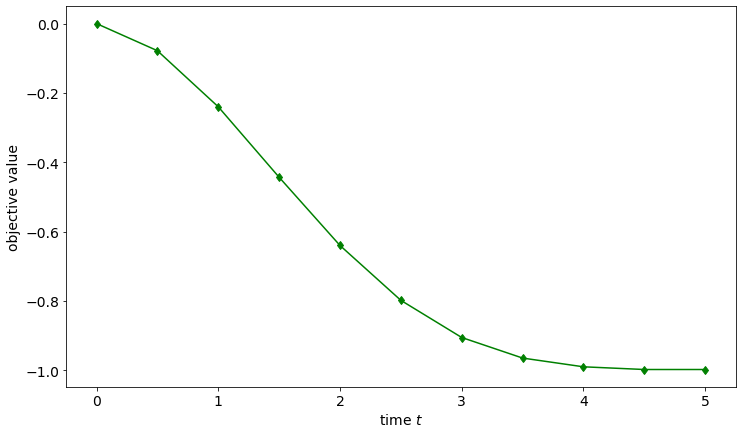

In [19]:
plt.figure(figsize=(12, 7))
plt.plot(np.linspace(0, T, N+1), probabilities[0, :] - probabilities[1, :], 'gd-')
plt.xticks(fontsize=14)
plt.xlabel('time $t$', fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('objective value', fontsize=14);

## Trotterized Annealing: Multiple Qubits

Suppose an Ising Hamiltonian corresponding to a QUBO:
$$
H_C = \sum_{i\neq j=0}^{n-1} \tilde{A}_{ij} \sigma_Z^i \otimes \sigma_Z^j + \sum_{i=0}^{n-1} \tilde{b}_i \sigma_Z^i.
$$
Since all terms are diagonal and commute, we have 

$$
e^{-iH_C\gamma} = \prod_{i\neq j=0}^{n-1} e^{-i \tilde{A}_{ij} \sigma_Z^i \otimes \sigma_Z^j \gamma} \, \prod_{i=0}^{n-1} e^{-i \tilde{b}_i \sigma_Z^i \gamma}
$$

For $\sigma_Z^i$, this again results in $R_Z$ gates.

For $\sigma_Z^i \otimes \sigma_Z^j$, we need to implement
$R_{ZZ}(\gamma) = e^{-i \sigma_Z^i \otimes \sigma_Z^j \gamma/2}$.

For $H_X$ we can just apply single qubit $R_X$ gates.

$R_{ZZ}(\gamma)$ can be constructed as follows:

In [20]:
gamma = Parameter('gamma')
qc1 = QuantumCircuit(2)
qc1.cx(0, 1)
qc1.rz(gamma, 1)
qc1.cx(0, 1)
qc1.draw()

q_0: ──■─────────────────■──
     ┌─┴─┐┌───────────┐┌─┴─┐
q_1: ┤ X ├┤ RZ(gamma) ├┤ X ├
     └───┘└───────────┘└───┘

or using the implementation directly provided by Qiskit:

In [21]:
qc2 = QuantumCircuit(2)
qc2.rzz(gamma, 0, 1)
qc2.draw()

q_0: ─■──────────
      │ZZ(gamma) 
q_1: ─■──────────

## Trotterized Annealing: MaxCut

In [22]:
from qiskit.circuit.library import QAOAAnsatz

In [23]:
# construct parameters from annealing schedule
T = 10
N = 20
gammas, betas = construct_schedule(T, N)

# construct ansatz
ansatz = QAOAAnsatz(H, N+1)

# bind parameters and evaluate circuit
qc = ansatz.bind_parameters(0.5*np.array(gammas + betas))
sv = Statevector.from_instruction(qc)

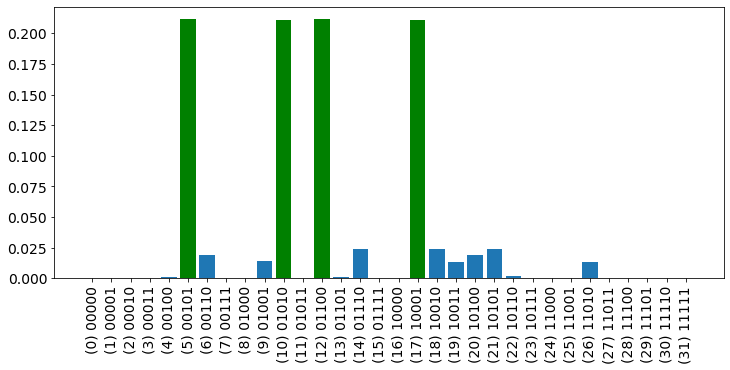

In [24]:
# plot probabilities
probabilities = sv.probabilities()
plt.figure(figsize=(12, 5))
plt.bar(range(2**n), probabilities)
plt.bar(opt_indices, probabilities[opt_indices], color='g')
plt.xticks(range(2**n), ['('+str(i)+') {0:05b}'.format(i) for i in range(2**n)], rotation=90, fontsize=14)
plt.yticks(fontsize=14);

In [25]:
# draw trotterized annealing circuit for MaxCut
qc.draw()

┌───┐┌───┐┌───────┐┌───┐┌───┐┌───────┐┌───┐┌───┐┌───────┐         ┌───┐»
q_0: ┤ H ├┤ X ├┤ RZ(0) ├┤ X ├┤ X ├┤ RZ(0) ├┤ X ├┤ X ├┤ RZ(0) ├─────────┤ X ├»
     ├───┤└─┬─┘└───────┘└─┬─┘└─┬─┘└───────┘└─┬─┘└─┬─┘└─┬───┬─┘┌───────┐└─┬─┘»
q_1: ┤ H ├──■─────────────■────┼─────────────┼────┼────┤ X ├──┤ RZ(0) ├──┼──»
     ├───┤                     │             │    │    └─┬─┘  └───────┘  │  »
q_2: ┤ H ├─────────────────────■─────────────■────┼──────■───────────────┼──»
     ├───┤                                        │                      │  »
q_3: ┤ H ├────────────────────────────────────────■──────────────────────■──»
     ├───┤                                                                  »
q_4: ┤ H ├──────────────────────────────────────────────────────────────────»
     └───┘                                                                  »
«          ┌───┐┌───────┐         ┌───┐┌───────┐┌───────────────────────┐»
«q_0: ─────┤ X ├┤ RZ(0) ├─────────┤ X ├┤ RZ(0) ├┤ RX(-1.00000000000000) ├»
«     ┌───┐└─┬─┘└─┬───┬─┘┌───────┐└─┬─┘└─┬───┬─┘└─────────┬───┬─────────┘»
«q_1: ┤ X ├──┼────┤ X ├──┤ RZ(0) ├──┼────┤ X ├────────────┤ X ├──────────»
«     └─┬─┘  │    └─┬─┘  └───────┘  │    └─┬─┘            └─┬─┘          »
«q_2: ──■────┼──────┼───────────────┼──────┼────────────────┼────────────»
«            │      │               │      │                │            »
«q_3: ───────┼──────■───────────────┼──────■────────────────┼────────────»
«            │                      │                       │            »
«q_4: ───────■──────────────────────■───────────────────────■────────────»
«                                                                        »
«                                                                ┌───┐  »
«q_0: ───────────────────────────────────────────────────────────┤ X ├──»
«     ┌───────┐         ┌───┐┌───────┐┌───────────────────────┐  └─┬─┘  »
«q_1: ┤ RZ(0) ├─────────┤ X ├┤ RZ(0) ├┤ RX(-1.00000000000000) ├────■────»
«     └─┬───┬─┘┌───────┐└─┬─┘└─┬───┬─┘└─────────┬───┬─────────┘┌───────┐»
«q_2: ──┤ X ├──┤ RZ(0) ├──┼────┤ X ├────────────┤ X ├──────────┤ RZ(0) ├»
«       └─┬─┘  └───────┘  │    └─┬─┘            └─┬─┘          └───────┘»
«q_3: ────■───────────────┼──────■────────────────┼─────────────────────»
«                         │                       │                     »
«q_4: ────────────────────■───────────────────────■─────────────────────»
«                                                                       »
«     ┌────────────────────────┐  ┌───┐                           ┌───┐»
«q_0: ┤ RZ(0.0500000000000000) ├──┤ X ├───────────────────────────┤ X ├»
«     └────────────────────────┘  └─┬─┘                           └─┬─┘»
«q_1: ──────────────────────────────■───────────────────────────────┼──»
«               ┌───┐           ┌───────┐┌───────────────────────┐  │  »
«q_2: ──────────┤ X ├───────────┤ RZ(0) ├┤ RX(-1.00000000000000) ├──■──»
«               └─┬─┘           └─┬───┬─┘└───────┬───────┬───────┘┌───┐»
«q_3: ────────────┼───────────────┤ X ├──────────┤ RZ(0) ├────────┤ X ├»
«                 │               └─┬─┘          └───────┘        └─┬─┘»
«q_4: ────────────■─────────────────■───────────────────────────────■──»
«                                                                      »
«     ┌────────────────────────┐          ┌───┐          ┌───┐»
«q_0: ┤ RZ(0.0500000000000000) ├──────────┤ X ├──────────┤ X ├»
«     └────────────────────────┘          └─┬─┘          └─┬─┘»
«q_1: ──────────────────────────────────────┼──────────────┼──»
«                                           │              │  »
«q_2: ──────────────────────────────────────■──────────────┼──»
«             ┌───────┐         ┌───────────────────────┐  │  »
«q_3: ────────┤ RZ(0) ├─────────┤ RX(-1.00000000000000) ├──■──»
«             ├───────┤         ├───────────────────────┤     »
«q_4: ────────┤ RZ(0) ├─────────┤ RX(-1.00000000000000) ├─────»
«             └───────┘         └───────────────────────┘     »
«

## From Trotterized Annealing to the<br>Quantum Approximate Optimization Algorithm (QAOA)

Trotterized Annealing leads to very long circuits, since the required simulation time and number of Trotter steps significantly increases with the problem size.

Thus, as introduced in [1], one can fix the number of steps to $p$, and let a classical optimizer find the best angles $\gamma_t$ and $\beta_t$, $t = 1, \ldots, p$, instead of following a fixed annealing schedule.

This is known as the <font color="blue"><b>Quantum Approximate Optimization Algorithm</b></font>.

<br>
<br>
[1] A Quantum Approximate Optimization Algorithm.<br>Edward Farhi, Jeffrey Goldstone, Sam Gutmann.<br>
https://arxiv.org/abs/1411.4028

## QAOA: Single Qubit Example $H_C = \sigma_Z$

In [26]:
from qiskit.algorithms.optimizers import COBYLA

In [27]:
# QAOA circuit for p = 1
gamma, beta = Parameter('gamma'), Parameter('beta')
qc = QuantumCircuit(1)
qc.h(0)
qc.rz(gamma, 0)
qc.rx(beta, 0)

def objective(params):
    qc_ = qc.bind_parameters({gamma: params[0], beta: params[1]})
    probs = Statevector.from_instruction(qc_).probabilities()
    return probs @ [1, -1]

optimizer = COBYLA()
result = optimizer.optimize(num_vars=2, objective_function=objective, initial_point=[0.5, 0.5])
print('optimal params:', np.round(result[0], decimals=4))
print('optimal value: ', np.round(result[1], decimals=4))
print('optimal state: ', np.round(Statevector.from_instruction(qc.bind_parameters(
    {gamma: result[0][0], beta: result[0][1]})).data, decimals=4))

optimal params: [-1.5708  1.5708]
optimal value:  -1.0
optimal state:  [-0.    -0.j      0.7071-0.7071j]


## QAOA: MaxCut

In [28]:
# illustrating the QAOA var form
p = 1
ansatz = QAOAAnsatz(H, p)
ansatz.draw()

global phase: 0
     ┌───┐┌───┐┌──────────────┐┌───┐┌───┐┌──────────────┐┌───┐┌───┐»
q_0: ┤ H ├┤ X ├┤ RZ(2.0*θ[0]) ├┤ X ├┤ X ├┤ RZ(2.0*θ[0]) ├┤ X ├┤ X ├»
     ├───┤└─┬─┘└──────────────┘└─┬─┘└─┬─┘└──────────────┘└─┬─┘└─┬─┘»
q_1: ┤ H ├──■────────────────────■────┼────────────────────┼────┼──»
     ├───┤                            │                    │    │  »
q_2: ┤ H ├────────────────────────────■────────────────────■────┼──»
     ├───┤                                                      │  »
q_3: ┤ H ├──────────────────────────────────────────────────────■──»
     ├───┤                                                         »
q_4: ┤ H ├─────────────────────────────────────────────────────────»
     └───┘                                                         »
«     ┌──────────────┐                ┌───┐     ┌───┐┌──────────────┐»
«q_0: ┤ RZ(2.0*θ[0]) ├────────────────┤ X ├─────┤ X ├┤ RZ(1.0*θ[0]) ├»
«     └────┬───┬─────┘┌──────────────┐└─┬─┘┌───┐└─┬─┘└────┬───┬─────┘»
«q_1: ─────┤ X ├──────┤ RZ(2.0*θ[0]) ├──┼──┤ X ├──┼───────┤ X ├──────»
«          └─┬─┘      └──────────────┘  │  └─┬─┘  │       └─┬─┘      »
«q_2: ───────■──────────────────────────┼────■────┼─────────┼────────»
«                                       │         │         │        »
«q_3: ──────────────────────────────────■─────────┼─────────■────────»
«                                                 │                  »
«q_4: ────────────────────────────────────────────■──────────────────»
«                                                                    »
«                     ┌───┐┌───────────────┐┌──────────────┐                »
«q_0: ────────────────┤ X ├┤ RZ(-1.0*θ[0]) ├┤ RX(2.0*θ[1]) ├────────────────»
«     ┌──────────────┐└─┬─┘└─────┬───┬─────┘└────┬───┬─────┘┌──────────────┐»
«q_1: ┤ RZ(1.0*θ[0]) ├──┼────────┤ X ├───────────┤ X ├──────┤ RZ(1.0*θ[0]) ├»
«     └──────────────┘  │        └─┬─┘           └─┬─┘      └────┬───┬─────┘»
«q_2: ──────────────────┼──────────┼───────────────┼─────────────┤ X ├──────»
«                       │          │               │             └─┬─┘      »
«q_3: ──────────────────┼──────────■───────────────┼───────────────■────────»
«                       │                          │                        »
«q_4: ──────────────────■──────────────────────────■────────────────────────»
«                                                                           »
«                                                                           »
«q_0: ──────────────────────────────────────────────────────────────────────»
«                     ┌───┐┌───────────────┐┌──────────────┐                »
«q_1: ────────────────┤ X ├┤ RZ(-1.0*θ[0]) ├┤ RX(2.0*θ[1]) ├────────────────»
«     ┌──────────────┐└─┬─┘└─────┬───┬─────┘└────┬───┬─────┘┌──────────────┐»
«q_2: ┤ RZ(2.0*θ[0]) ├──┼────────┤ X ├───────────┤ X ├──────┤ RZ(2.0*θ[0]) ├»
«     └──────────────┘  │        └─┬─┘           └─┬─┘      └──────────────┘»
«q_3: ──────────────────┼──────────■───────────────┼────────────────────────»
«                       │                          │                        »
«q_4: ──────────────────■──────────────────────────■────────────────────────»
«                                                                           »
«                                                                 »
«q_0: ────────────────────────────────────────────────────────────»
«                                                                 »
«q_1: ────────────────────────────────────────────────────────────»
«     ┌───┐┌───────────────┐┌──────────────┐                      »
«q_2: ┤ X ├┤ RZ(-1.0*θ[0]) ├┤ RX(2.0*θ[1]) ├──────────────────────»
«     └─┬─┘└─────┬───┬─────┘├──────────────┤┌───┐┌───────────────┐»
«q_3: ──┼────────┤ X ├──────┤ RZ(2.0*θ[0]) ├┤ X ├┤ RZ(-1.0*θ[0]) ├»
«       │        └─┬─┘      └──────────────┘└─┬─┘├───────────────┤»
«q_4: ──■──────────■──────────────────────────■──┤ RZ(-1.0*θ[0]) ├»
«                                               

In [29]:
# fix initial point for QAOA to ensure results are reproducible
initial_point = [0.29542919, 2.87976747]

In [30]:
from qiskit.algorithms import QAOA

qaoa_mes = QAOA(reps=1, optimizer=optimizer, initial_point=initial_point, 
                quantum_instance=Aer.get_backend('statevector_simulator'))
result = qaoa_mes.compute_minimum_eigenvalue(H)

print('optimal params:      ', result.optimal_parameters)
print('optimal value:       ', result.optimal_value)
print('optimal probability: ', sum(np.abs(result.eigenstate[opt_indices])**2))

optimal params:       {ParameterVectorElement(θ[0]): 0.2312741606132879, ParameterVectorElement(θ[1]): 2.856477676450839}
optimal value:        -1.7959726962003035
optimal probability:  0.294504738246959


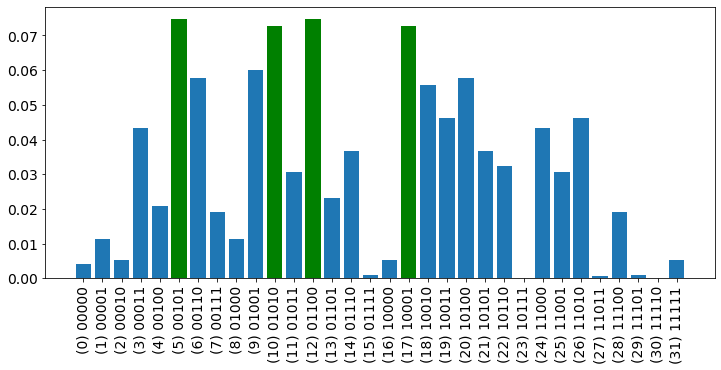

In [31]:
# plot probabilities
probabilities = np.abs(result.eigenstate)**2
plt.figure(figsize=(12, 5))
plt.bar(range(2**n), probabilities)
plt.bar(opt_indices, probabilities[opt_indices], color='g')
plt.xticks(range(2**n), ['('+str(i)+') {0:05b}'.format(i) for i in range(2**n)], rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [32]:
from qiskit_optimization.algorithms import MinimumEigenOptimizer

In [33]:
# construct QAOA as Minimum Eigensolver
qaoa_mes = QAOA(reps=1, optimizer=optimizer, quantum_instance=Aer.get_backend('statevector_simulator'))

# construct Minimum Eigen Optimizer based on QAOA
qaoa = MinimumEigenOptimizer(qaoa_mes)

# solve Quadratic Program
result = qaoa.solve(qp)

optimal function value: 5.0
optimal value: [1. 0. 1. 0. 0.]
status: SUCCESS


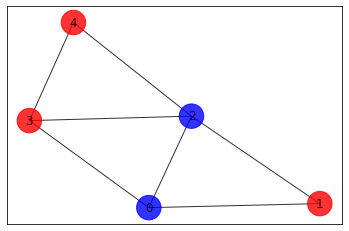

In [34]:
print(result)
plot_result(G, result.x)

# 4. What's next...

# Next Steps...

- Test the existing optimization algorithms on your own problems.
- Check out additional algorithms in Qiskit, e.g. 
    - `RecursiveMinimumEigenOptimizer`, 
    - `WarmStartedQAOA`,
    - `ADMM`, 
    - `GroverOptimizer`.
- Try first problems on real quantum devices.
- Contribute your own quantum optimization algorithms to Qiskit's Optimization module!

# Further Resources

<br>

- Medium article on Qiskit Optimization:<br>
https://medium.com/qiskit/ <br>
"A Walkthrough of Qiskit’s New Optimization Module"
<br>

- Qiskit Text Book:<br>
https://qiskit.org/textbook/ <br>
Sections on QAOA and Grover Search
<br>

- Qiskit Tutorials:<br>
https://qiskit.org/documentation/optimization/tutorials/ <br>
Tutorials on all algorithms, converters, etc.

<div>
    <center>
        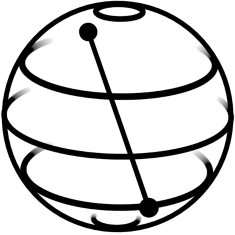
        <br>
        <br>
        Thank you!
    </center>
</div>